In [1]:
import numpy as np
import torch
import torch_directml
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm

First we must define the device to work on, this time we will be using DirectML because training will be done on an AMD RX 5700XT 

In [2]:
device = torch_directml.device()

Then we must download the datasets, both for testing and training.

In [3]:
ds = torchvision.datasets.MNIST(root = "./data", download = True, train = True) 

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:07<00:00, 1269182.34it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 191292.96it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:01<00:00, 1396808.34it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [4]:
x_total = torch.tensor(list(map(lambda z: np.array(z[0]), ds)), dtype=torch.float32).to(device) # Converting to tensor of tensors the list of first elements of the ds tuples 
y_total = (torch.nn.functional.one_hot(torch.tensor(list(map(lambda z: z[1], ds))), num_classes=10)).to(torch.float32).to(device) # Converting all labels to one hot encoding to see which number from 0 to 9 are they representing

C:\Users\srene\AppData\Local\Temp\ipykernel_18248\3138855485.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  x_total = torch.tensor(list(map(lambda z: np.array(z[0]), ds)), dtype=torch.float32).to(device) # Converting to tensor of tensors the list of first elements of the ds tuples


In [5]:
x_total.shape, y_total.shape

(torch.Size([60000, 28, 28]), torch.Size([60000, 10]))

Divido el dataset original en training y testing, creo sus loaders

In [6]:
x_train = x_total[:50000].view(-1,1,28,28)
y_train = y_total[:50000]
x_test = x_total[50000:].view(-1,1,28,28)
y_test = y_total[50000:]

train_dataset = TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader (dataset = train_dataset, batch_size = 32, shuffle = True)
test_dataset = TensorDataset(x_test, y_test)
test_loader = torch.utils.data.DataLoader (dataset = test_dataset, batch_size = 32, shuffle = True)


Creo el modelo


---



In [7]:
model = nn.Sequential(
    # First convolutional layer
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    # second convolutional layer
    nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # Flattening both convolutional layers
    nn.Flatten(),
    nn.Linear(64 * 14 * 14, 128),
    nn.ReLU(),
    nn.Linear(128,10)
).to(device)


Entreno el modelo con un loop de entrenamiento


In [ ]:
criterion = nn.MSELoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3)
num_epochs = 100

for epoch in range(num_epochs):
  for inputs, targets in tqdm(train_loader):
      inputs, targets = inputs.to(device).float(), targets.to(device).float() 
      optimizer.zero_grad()  # Reseting the gradient
      outputs = model(inputs)  # Forward pass
      loss = criterion(outputs.squeeze(), targets.float())  # Calculating loss
      loss.backward()  # Backpropagation
      optimizer.step()

  correct_predictions = 0
  total_predictions = 0

  with torch.no_grad(): # Testing the accuracy of the model on the test dataset per epoch
    for test_inputs, test_targets in test_loader:
      test_inputs, test_targets = test_inputs.to(device).float(), test_targets.to(device).long()
      test_outputs = model(test_inputs)
      _, predicted = torch.max(test_outputs, 1)
      correct_predictions += (predicted == torch.argmax(test_targets, dim=1)).sum().item()
      total_predictions += test_targets.size(0)

  accuracy = (correct_predictions / total_predictions) * 100
  print(f"Accuracy: {accuracy}")

100%|██████████| 1563/1563 [00:03<00:00, 412.60it/s]


Accuracy: 98.36


100%|██████████| 1563/1563 [00:03<00:00, 418.73it/s]


Accuracy: 98.44000000000001


100%|██████████| 1563/1563 [00:03<00:00, 418.23it/s]


Accuracy: 98.38


100%|██████████| 1563/1563 [00:03<00:00, 409.05it/s]


Accuracy: 98.42


100%|██████████| 1563/1563 [00:03<00:00, 434.24it/s]


Accuracy: 98.4


100%|██████████| 1563/1563 [00:03<00:00, 427.90it/s]


Accuracy: 98.39


100%|██████████| 1563/1563 [00:03<00:00, 415.01it/s]


Accuracy: 98.41


100%|██████████| 1563/1563 [00:03<00:00, 406.26it/s]


Accuracy: 98.42


100%|██████████| 1563/1563 [00:03<00:00, 393.33it/s]


Accuracy: 98.46000000000001


100%|██████████| 1563/1563 [00:03<00:00, 407.34it/s]


Accuracy: 98.44000000000001


Only some the last epochs of training are showed.

Testing the model (that reached 98.4% of accuracy on testing!) with a particular image of the test dataset

Predicted class: 8


C:\Users\srene\AppData\Local\Temp\ipykernel_18248\759376564.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(image)).to(device)


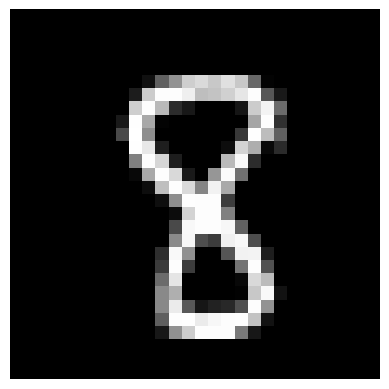

In [10]:
image, label = test_dataset[1]
image = image.unsqueeze(0).to(device) # Adding one more dimension to the position 0 so that it can go through the conv2ds layers

# Making the prediction without gradient descent so it's faster
with torch.no_grad():
    output = model(torch.tensor(image)).to(device)

# Obtaining the predicted class (index with highest probability)
predicted_class = output.argmax(dim=1).item()

print(f'Predicted class: {predicted_class}')
image = image.squeeze(0).cpu().numpy()  # Eliminates the added dimension to the batch and moves it to the cpu

plt.imshow(image[0], cmap='gray')
plt.axis('off')
plt.show()